In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import linalg as LA

import csv
import os
import json
import math
import time
import pickle

from glob import glob
from collections import defaultdict
from scipy import signal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from utilities import *
from utilitiesDL import *

## Parameter Configuration

In [2]:
jsonFileName = './inputJson/genData.json'

f = open(jsonFileName)
inputJson = json.load(f)
dataPathBase = inputJson['dataPathBase']
dataType = inputJson['dataType']
cudaID = 5
f.close()

print("Datatype:", dataType)
if dataType == 'survey':
    fs = 1000 # 1 kHz
    nSubC = 30
    nRX = 3
    
    dSampFactor = 2
    activities = ['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']
    # activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']

torch.set_num_threads(1)
if cudaID >= 0:
    device = torch.device("cuda:"+str(cudaID))
    cudaAvbl = True
else:
    device = torch.device("cpu")
    cudaAvbl = False

padLen = 9
if dataType == "survey":
    dataPath = dataPathBase + "HAR_survey/"
dataDict = {activity:[] for activity in activities}
for activity in activities:
    dataDict[activity] = defaultdict(list)
dataPath = dataPath + "noWin_pad_" + str(padLen) + "/"

Datatype: survey


In [3]:
dataDict = {file:[] for file in activities}
lenList = []
ampList = []
for actInd, activity in enumerate(activities):
    longestLen = 0
    shortestLen = 10000

    dataDict[activity] = defaultdict(list)

    xxLoadNP = np.load(dataPath + "xx_" + activity + ".npy", allow_pickle=True)
    # if xxLoadNP.shape[0] > longestLen:
    #     longestLen = xxLoadNP.shape[0]
    for dataInd, data in enumerate(xxLoadNP):
        if data.shape[0] > longestLen:
            longestLen = data.shape[0]
        if data.shape[0] < shortestLen:
            shortestLen = data.shape[0]
        # if data.shape[0] < lenThres:
        dataDict[activity]['input'].append(data)
        ampList.append(LA.norm(torch.Tensor(data)))
        # data = torch.Tensor(data) / LA.norm(torch.Tensor(data)) * torch.numel(torch.Tensor(data))
        lenList.append(LA.norm(torch.Tensor(data)))
        
        dataDict[activity]['label'] = actInd*torch.ones(len(dataDict[activity]['input']), dtype=int, device=device)
    print(activity, len(dataDict[activity]['input']), len(dataDict[activity]['label']), shortestLen, longestLen)
# plt.hist(lenList, bins=20)
# plt.hist(ampList, bins=20)

bed 79 79 1920 4820
fall 79 79 1570 3300
run 80 80 3300 11310
sitdown 80 80 1250 3440
standup 79 79 1060 3230
walk 80 80 5440 10010


## Create training, test torch dataset

In [4]:
batchSize = 1

trData = list()
tsData = list()
for activity in activities:
    dataset = CSIDataset(dataDict[activity], device,\
                        normalize=True,\
                        nSubC=nSubC,\
                        nRX=nRX,\
                        padLen=padLen)
    nTrData = np.floor(len(dataset)*0.8).astype(int)
    nTsData = np.floor(len(dataset)*0.2).astype(int)
    trData.append(torch.utils.data.Subset(dataset, range(nTrData)))
    tsData.append(torch.utils.data.Subset(dataset, range(nTrData, nTrData+nTsData)))
    print(activity, nTrData, nTsData, len(dataset))

trDataset = torch.utils.data.ConcatDataset(trData) # concatenating dataset lists
tsDataset = torch.utils.data.ConcatDataset(tsData)

trLoader = DataLoader(trDataset, batch_size=batchSize, shuffle=True, collate_fn=collate_fn)
tsLoader = DataLoader(tsDataset, batch_size=batchSize, shuffle=True, collate_fn=collate_fn)
print("# of tr data:", len(trDataset), "# of ts data:", len(tsDataset))

bed 63 15 79
fall 63 15 79
run 64 16 80
sitdown 64 16 80
standup 63 15 79
walk 64 16 80
# of tr data: 381 # of ts data: 93


In [5]:
LSTMLoss = torch.nn.CrossEntropyLoss()
nHidden = 200
LR = 5e-5
maxPatience = 30
nEpoch = 200
bidirectional = True
if bidirectional:
    modelName = 'BiLSTM'
else:
    modelName = 'LSTM'

modelFileName = dataType + "_" + modelName + "_H_" + str(nHidden) + ".cpkt"
HARNetSavePath = './savedModels/LSTM/' + modelFileName
print('save model path:', HARNetSavePath)
fromInit = False

HARNet = VariableLSTMNet(nClasses=len(activities),\
                input_size=nSubC*nRX,\
                bidirectional=bidirectional,\
                hidden_size=nHidden,\
                num_layers=1,\
                device=device)
HARNet.to(device)

if fromInit:
    HARNet.apply(init_weights)
else:
    HARNet.load_state_dict(torch.load(HARNetSavePath))
opt = torch.optim.Adam(HARNet.parameters(), lr=LR)

save model path: ./savedModels/LSTM/survey_BiLSTM_H_200.cpkt


In [6]:
bestAcc = 0.0
patience = 0
fastConvg = True

torch.set_num_threads(1)
print('save model path:', HARNetSavePath)
for epoch in range(nEpoch):
    runningLoss = 0.0
    HARNet.train()      
    for trInput, trLabel in trLoader:
        trLabel = trLabel.to(device)
        # print(trLabel)
        opt.zero_grad()
        
        trOutput = HARNet(trInput)
        # print(trOutput.shape)
        trloss = LSTMLoss(trOutput, trLabel)
        trloss.backward()
        opt.step()
        runningLoss += trloss.item()

    avgTrLoss = runningLoss / len(trLoader)
    accTrain = getAcc(trLoader, padLen, HARNet, variableLen=True)

    runningLoss = 0.0
    for tsInput, tsLabel in tsLoader:
        tsLabel = tsLabel.to(device)
        opt.zero_grad()
        # tsInput = tsData['input']
        # tsLabel = tsData['label']
        
        tsOutput = HARNet(tsInput)
        tsloss = LSTMLoss(tsOutput, tsLabel)
        runningLoss += tsloss.item()

    avgTsLoss = runningLoss / len(tsLoader)
    accTest = getAcc(tsLoader, padLen, HARNet, variableLen=True)

    print('Epoch: %d, trLoss: %.3f, trAcc: %.3f, tsLoss: %.3f, tsAcc: %.3f'\
        % (epoch, avgTrLoss, accTrain, avgTsLoss, accTest))
    if bestAcc < accTest:
        bestAcc = accTest
        print('saving model')
        torch.save(HARNet.state_dict(), HARNetSavePath)  # saving model with best test accuracy
        patience = 0

    # print(trData.shape, trLabel.shape)
    # early stopping if model converges twice
    patience += 1
    if patience > maxPatience:
        if fastConvg:
            LR = LR/10
            opt = torch.optim.Adam(HARNet.parameters(), lr=LR)
            patience = 0
            fastConvg = False
            print('fast convergence ends')
        else:
            break

print('Training finished')

save model path: ./savedModels/LSTM/survey_BiLSTM_H_200_noWin.cpkt


/home/byk004/24-RT_adv_HAR/utilities.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], device=self.device).long()
/home/byk004/24-RT_adv_HAR/utilities.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_padded = pad_sequence([torch.tensor(seq) for seq in inputs],


KeyboardInterrupt: 

/home/byk004/24-RT_adv_HAR/utilities.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], device=self.device).long()
/home/byk004/24-RT_adv_HAR/utilities.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_padded = pad_sequence([torch.tensor(seq) for seq in inputs],


2101.0 0.0
6171.0 0.0
2540.999755859375 0.0
2751.0 0.0
7461.0 0.0
2611.0 0.0
9661.0 0.0
6680.99951171875 0.0
2271.0 0.0
3530.999755859375 0.0
5621.0 0.0
6141.0 0.0
8271.0 0.0
2541.0 0.0
7420.99951171875 0.0
3080.999755859375 0.0
1590.9998779296875 0.0
2071.0 0.0
6610.99951171875 0.0
2880.999755859375 0.0
1960.9998779296875 0.0
9291.0 0.0
2171.0 0.0
2101.0 0.0
2071.0 0.0
9081.0 0.0
8041.0 0.0
1921.0 0.0
6840.99951171875 0.0
8811.0 0.0
4361.0 0.0
5151.00048828125 0.0
2001.0 0.0
6201.00048828125 0.0
3091.000244140625 0.0
3451.000244140625 0.0
9120.9990234375 0.0
4100.99951171875 0.0
5491.0 0.0
6891.0 0.0
2681.0 0.0
2891.0 0.0
2231.0 0.0
6611.0 0.0
6890.99951171875 0.0
2641.0 0.0
3221.000244140625 0.0
4201.0 0.0
2380.999755859375 0.0
7661.00048828125 0.0
9900.9990234375 0.0
1730.9998779296875 0.0
2511.000244140625 0.0
6131.0 0.0
6501.0 0.0
1351.0 0.0
1930.9998779296875 0.0
1520.9998779296875 0.0
3970.999755859375 0.0
1700.9998779296875 0.0
1520.9998779296875 0.0
2611.0 0.0
3021.00024414062

[Text(0, 0, 'Lie down'),
 Text(0, 1, 'Fall'),
 Text(0, 2, 'Run'),
 Text(0, 3, 'Sit down'),
 Text(0, 4, 'Stand up'),
 Text(0, 5, 'Walk')]

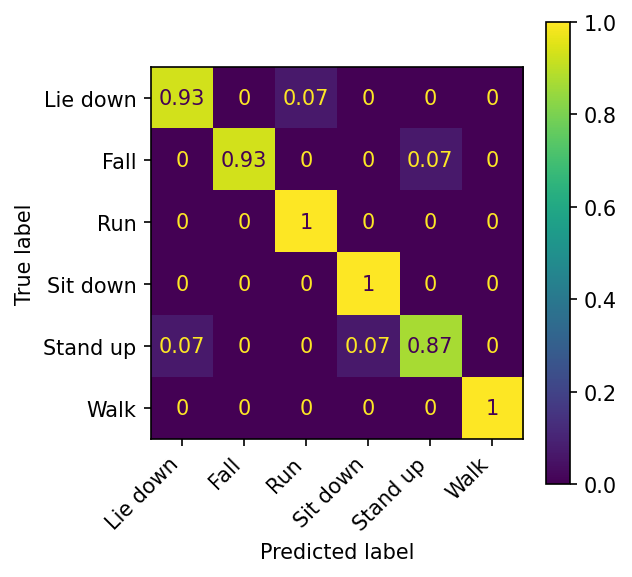

In [6]:
noiseAmpRatio = 0.0
variableLen = True
pred, target = getPreds(tsLoader, padLen, HARNet, variableLen, noiseAmpRatio=noiseAmpRatio)
cm = confusion_matrix(target,pred,normalize ='true')
for i in range(len(activities)):
    for j in range(len(activities)):
        cm[i, j] = round(cm[i, j], 2)

# print(pred)
# print(target)
print(activities)
activityLabel = ['Lie down', 'Fall', 'Run', 'Sit down', 'Stand up', 'Walk']

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

ax.set_xticklabels(activityLabel, rotation=45, ha='right')
ax.set_yticklabels(activityLabel)

In [14]:
noiseAmpRatioList = [1e-2]
# noiseAmpRatioList = [1e-5, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5]

nHidden = 200
thres = 60
batchSize = 1
nLayer = 1
bidirectional = True
if bidirectional:
    modelName = "BiLSTM"
else:
    modelName = "LSTM"
# HARNetSavePath = './savedModels/' + dataType + '_' + modelName + '_H_' + str(nHidden) + '_th_' + str(thres) +\
#      '_L_' + str(nLayer) + '.cpkt'
HARNetSavePath = './savedModels/LSTM/survey_BiLSTM_H_' + str(nHidden) + '.cpkt'

HARNet = VariableLSTMNet(nClasses=len(activities),\
                input_size=nSubC*nRX,\
                bidirectional=bidirectional,\
                hidden_size=nHidden,\
                num_layers=1,\
                device=device)

HARNet.load_state_dict(torch.load(HARNetSavePath))
HARNet.to(device)
HARNet.eval()
loaderPadLen = padLen
for noiseAmpRatio in noiseAmpRatioList:
    accTest = getAcc(tsLoader,\
                    padLen,\
                    HARNet,\
                    variableLen=True,\
                    noiseAmpRatio=noiseAmpRatio,\
                    noiseType='FGM')
    # accTest = getAcc(tsLoader, padLen, HARNet, variableLen=True)
    print('NoiseAmpRatio:', noiseAmpRatio, ' Test accuracy:', accTest)

NameError: name 'datasetAct' is not defined

## Save CSI data and FGM noise

In [35]:
nData = 0
batchSize = 1
padLen = 9

if bidirectional:
    modelName = "BiLSTM"
else:
    modelName = "LSTM"
modelFileName = 'survey_' + modelName + '_H_' + str(nHidden)

inputList = []
FGMList = []
labelList = []

for actInd, activity in enumerate(activities):
    print('activity:', activity, end=' ')
    datasetAct = CSIDataset(dataDict[activity], device)

    model = HARNet
    loader = DataLoader(datasetAct, batch_size=batchSize, shuffle=False)
    noiseAmpRatio = .1

    device = model.device
    model.to(device)
    model.train()
    # loss = loss(model())

    dataInput_fileName = "/project/iarpa/wifiHAR/HAR_survey/noWin_pad_" +\
        str(padLen) + "_FGM/input_" + modelFileName + "_" + activity
    dataFGM_fileName = "/project/iarpa/wifiHAR/HAR_survey/noWin_pad_" +\
        str(padLen) + "_FGM/FGM_" + modelFileName + "_" + activity
    
    for batch in loader:
        batchInput = batch['input']
        batchInput = batchInput * torch.numel(batchInput) /\
            (LA.norm(batchInput) * nSubC * nRX)

        batchInputWoPad = batchInput[:, padLen:, :]      

        inputFlatten = batchInputWoPad.view(batchInputWoPad.shape[0], -1)
        noiseAmp = LA.norm(inputFlatten, dim=1) * noiseAmpRatio
        batchLabel = batch['label']
        
        batchInputWoPad.requires_grad = True
        model.zero_grad()
        loss = nn.CrossEntropyLoss()
        lossOutput = loss(model(batchInputWoPad), batchLabel)
        lossOutput.backward()
        noise = (batchInputWoPad.grad.data).view(batchInputWoPad.shape[0], -1)
        noiseNorm = torch.mul(torch.div(noise, LA.norm(noise, dim=1).unsqueeze(1)),\
                              noiseAmp.unsqueeze(1))

        # print(LA.norm(batchInput).item(), LA.norm(noiseNorm).item())
        inputList.append(torch.squeeze(batchInput).cpu().detach())
        batchNoiseNorm = noiseNorm.view(batchInputWoPad.shape)
        FGMList.append(torch.squeeze(batchNoiseNorm).cpu().detach())
        labelList.append([actInd])

print('nDataAct:', len(inputList))
    # np.save(dataInput_fileName, np.array(inputList, dtype=object), allow_pickle=True)
    # np.save(dataFGM_fileName, np.array(FGMList, dtype=object), allow_pickle=True)

print('nData:', nData)

activity: bed activity: fall activity: run activity: sitdown activity: standup activity: walk nDataAct: 477
nData: 0


## Load saved pre-trained LSTM model and evaluate (noise may be added)

In [40]:
noiseAmpRatioList = [1e-2]
# noiseAmpRatioList = [1e-5, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5]

nHidden = 200
thres = 60
batchSize = 200
nLayer = 1
bidirectional = True
if bidirectional:
    modelName = "BLSTM"
else:
    modelName = "LSTM"
HARNetSavePath = './savedModels/selected/survey_BiLSTM_H_200.cpkt'

HARNet = VariableLSTMNet(nClasses=len(activities),\
                input_size=nSubC*nRX,\
                bidirectional=bidirectional,\
                hidden_size=nHidden,\
                num_layers=1,\
                device=device)
HARNet.load_state_dict(torch.load(HARNetSavePath))
HARNet.to(device)

loaderPadLen = padLen
for noiseAmpRatio in noiseAmpRatioList:
    correct = 0.0
    # accTest = getAcc(trLoader, 9, HARNet, variableLen=True,\
    #                  noiseAmpRatio=noiseAmpRatio, noiseType='FGM')
    print(len(inputList), len(FGMList), len(labelList))
    # for trInput, trFGM, trLabel in zip(inputList, FGMList, labelList):
    #     print(trInput.shape)
    pred_l, label_l = getPredsGAIL(inputList, FGMList, torch.Tensor(labelList), HARNet,\
                        noiseAmpRatio=noiseAmpRatio, padLen=padLen)    
    for pred, label in zip(pred_l, label_l):
        print(pred, label.item())
        nData += 1
        correct += (pred == label)

    print('NoiseAmpRatio:', noiseAmpRatio, ' Test accuracy:', correct/len(inputList))

477 477 477
3 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
3 tensor([0.])
0 tensor([0.])
3 tensor([0.])
3 tensor([0.])
3 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
2 tensor([0.])
5 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
1 tensor([0.])
2 tensor([0.])
3 tensor([0.])
2 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
2 tensor([0.])
0 tensor([0.])
0 tensor([0.])
3 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
3 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
3 tensor([0.])
4 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
5 tensor([0.])
0 tensor([0.])
2 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.]

In [ ]:
nDataTs = 0
for tsBatch in tsLoader:
    nDataTs += tsBatch['obs'].shape[0]

lineBreakCount = 0
for noiseAmpRatio in noiseAmpRatioList:
    correct = 0.
    for trAgentBatch in tsLoader:
        trObsBatchwoPad = trAgentBatch['obs'][:, padLen:, :]
        pred_l,label_l = getPredsGAIL(trObsBatchwoPad, trAgentBatch['FGM'], trAgentBatch['label'],\
                                        HARNet, noiseAmpRatio)
        for pred, label in zip(pred_l, label_l):
            correct += (pred == label)
    print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTs), end=' ')

    lineBreakCount += 1
    if lineBreakCount == 4:
        print('')
        lineBreakCount = 0


In [ ]:
nData = 0
batchSize = 1
for actInd, activity in enumerate(activities):
    datasetAct = CSIDataset(dataDict[activity], device)
    loader = DataLoader(datasetAct, batch_size=batchSize, shuffle=False)

    for batch in loader:
        nData += batch['input'].shape[0]
print('nData:', nData, end=' ')


correct = 0.
for actInd, activity in enumerate(activities):
    datasetAct = CSIDataset(dataDict[activity], device)

    model = HARNet
    loader = DataLoader(datasetAct, batch_size=batchSize, shuffle=False)
    noiseAmpRatio = .1

    device = model.device
    model.to(device)
    model.train()

    dataInputPaddedAct = torch.empty((0, ((winLen//2+padLen) * nSubC*nRX))).to(device)
    dataNoiseAct = torch.empty((0, ((winLen//2) * nSubC*nRX))).to(device)
    dataInput_fileName = "/project/iarpa/wifiHAR/HAR_survey/noWin_FGM_pad_" +\
        str(padLen) + "/input_" + dataType + "_LSTM_H_200_th_" + str(thres) + "_L_1_" + activity + ".npy"
    dataNoise_fileName = "/project/iarpa/wifiHAR/HAR_survey/noWin_FGM_pad_" +\
        str(padLen) + "/noise_" + dataType + "_LSTM_H_200_th_" + str(thres) + "_L_1_" + activity + ".npy"

    for batch in loader:
        model.zero_grad()
        model.train()
        inputFlatten = batch['input'].view(batch['input'].shape[0], -1)
        noiseAmp = LA.norm(inputFlatten, dim=1) * (winLen//2) / (winLen//2 + padLen) * noiseAmpRatio

        batcchInputWoPad = batch['input'][:, padLen:, :]
        batcchInputWoPad.requires_grad = True
        loss = nn.CrossEntropyLoss()
        loss = loss(model(batcchInputWoPad), batch['label'])
        loss.backward()
        batchNoise = (batcchInputWoPad.grad.data).view(batcchInputWoPad.shape[0], -1)
        batchNoise = torch.mul(torch.div(batchNoise, LA.norm(batchNoise, dim=1).unsqueeze(1)),\
                            noiseAmp.unsqueeze(1))
        batchInput = batch['input'].view(batch['input'].shape[0], -1)

        batchLabel =\
            actInd * torch.ones_like(torch.empty(batchInput.shape[0], device=device), dtype=int)

        pred_l,label_l = getPredsGAIL(batcchInputWoPad, batchNoise, batchLabel,\
                                HARNet, noiseAmpRatio)
        for pred, label in zip(pred_l, label_l):
            correct += (pred == label)


        # print(batchInput.shape, batchNoise.shape, batcchInputWoPad.shape)
        dataInputPaddedAct = torch.cat((dataInputPaddedAct, batchInput), 0)
        dataNoiseAct = torch.cat((dataNoiseAct, batchNoise), 0)
        # print(dataInputPaddedAct.shape, dataNoiseAct.shape)

    dataInputPaddedActNp = dataInputPaddedAct.cpu().detach().numpy()
    dataNoiseActNp = dataNoiseAct.cpu().detach().numpy()
    print('activity:', activity, dataInputPaddedActNp.shape, dataNoiseActNp.shape)
    with open(dataInput_fileName, 'wb') as f:
        np.save(f, dataInputPaddedActNp)
    with open(dataNoise_fileName, 'wb') as f:
        np.save(f, dataNoiseActNp)

print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nData))


## save non-windowed data (but dowmsanpled)

In [ ]:
padLen = 9
print(dataPath)
noWindDataPath = dataPath + "noWin_pad" + str(padLen) + "/"
for activity in activities:
    if dataType == "survey":
        fileNameList = glob(dataPath + "/input_" + activity + "*.csv")
        outputXXFileName = noWindDataPath + "xx_" + activity

        print(activity, len(fileNameList))

        # xx = np.empty([0, (winLen//dSampFactor + padSize), nSubC*nRX], float)
    dataList = []

    for fileIndex, fileName in enumerate(fileNameList):
        data = np.array([[float(elm) for elm in v] for v in csv.reader(open(fileName, 'r'))])
        annotFileName = fileName.replace('input', 'annotation')
        annot = np.array([[str(elm) for elm in v] for v in csv.reader(open(annotFileName, 'r'))])
        annotDownSamp = annot[::dSampFactor]

        indActs = np.where(annot[:, 0] == activity)[0]
        indPad = np.arange(indActs[0]-padLen*dSampFactor, indActs[0], dSampFactor)
        indActswithPad = np.concatenate((indPad, indActs))
        # print(indActswithPad.shape)
        # print(indPad, indActs[:5], indActswithPad[:15])
        
        dataActs = data[indActswithPad, 1:1+nSubC*nRX]
        dataList.append(dataActs)

    np.save(outputXXFileName, np.array(dataList, dtype=object), allow_pickle=True)
    # with open(outputXXFileName, "w+") as f:
    #     pickle.dump(dataList, f)